In [1]:
import matplotlib.pyplot as plt
from jax.random import PRNGKey, split
import jax.numpy as jnp
import jax

from tqdm import tqdm

from jax import config
config.update("jax_enable_x64", True)

from data import generate_data, generate_observation_matrix
from loss import create_loss
from network import init_net, compute_end_to_end, compute_factor, kwon_compress_network
from solver import train
from utils import compose, svd

## Deep Matrix Completion

In [2]:
key = PRNGKey(0)

# Simulated Data
d = 100
r = 10

key, subkey = split(key)
target = generate_data(key=subkey, shape=(d, d), rank=r)

key, subkey = split(key)
percent_observed = 0.3
mask = generate_observation_matrix(key=subkey, percent_observed=percent_observed, shape=(d, d))

train_loss_fn = create_loss(target, mask=mask)
test_loss_fn = create_loss(target, mask=1-mask)
loss_fn_dict = {
    'train': train_loss_fn,
    'test': test_loss_fn
}
network_fn = compute_end_to_end

2023-10-09 12:40:54.220901: W external/xla/xla/service/platform_util.cc:198] unable to create StreamExecutor for CUDA:0: failed initializing StreamExecutor for CUDA device ordinal 0: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_DEVICE_UNAVAILABLE: CUDA-capable device(s) is/are busy or unavailable
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
depth = 3
init_scale = 1e-2

key, subkey = split(key)

# Instatiating the original wide network
init_weights = init_net(
    key=subkey, 
    input_dim=d, 
    output_dim=d, 
    width=d, 
    depth=depth, 
    init_scale=init_scale
)

tol = 1e-9
step_size = 3
n_outer_loops = 1000
n_inner_loops = 100

In [4]:
orig_result = train(
    init_weights=init_weights,
    network_fn=network_fn,
    loss_fn_dict=loss_fn_dict,
    n_outer_loops=n_outer_loops,
    step_size=step_size,
    tol=tol,
    n_inner_loops=n_inner_loops,
    save_weights=True
)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [5]:
U_true, _, V_true = svd( target )

In [6]:
U_L_orig = [svd(orig_result['weights'][i][-1])[0] for i in range(len(orig_result['weights']))]

In [7]:
V_1_orig = [svd(orig_result['weights'][i][0])[2] for i in range(len(orig_result['weights']))]

In [8]:
U_angle_mc = [jnp.abs(jnp.dot(U_L_orig[i][:, 0], U_true[:, 0])) for i in range(len(U_L_orig))]

In [9]:
V_angle_mc = [jnp.abs(jnp.dot(V_1_orig[i][:, 0], V_true[:, 0])) for i in range(len(V_1_orig))]

## Deep Matrix Factorization

In [10]:
key = PRNGKey(0)

# Simulated Data
d = 100
r = 10

key, subkey = split(key)
target = generate_data(key=subkey, shape=(d, d), rank=r)

train_loss_fn = create_loss(target)
test_loss_fn = create_loss(target)

loss_fn_dict = {
    'train': train_loss_fn,
    'test': test_loss_fn
}
network_fn = compute_end_to_end

In [11]:
depth = 3
init_scale = 1e-2

key, subkey = split(key)

# Instatiating the original wide network
init_weights = init_net(
    key=subkey, 
    input_dim=d, 
    output_dim=d, 
    width=d, 
    depth=depth, 
    init_scale=init_scale
)

tol = 1e-9
step_size = 3
n_outer_loops = 1000
n_inner_loops = 100

In [12]:
orig_result = train(
    init_weights=init_weights,
    network_fn=network_fn,
    loss_fn_dict=loss_fn_dict,
    n_outer_loops=n_outer_loops,
    step_size=step_size,
    tol=tol,
    n_inner_loops=n_inner_loops,
    save_weights=True
)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
U_true, _, V_true = svd( target )
U_L_orig = [svd(orig_result['weights'][i][-1])[0] for i in range(len(orig_result['weights']))]
V_1_orig = [svd(orig_result['weights'][i][0])[2] for i in range(len(orig_result['weights']))]
U_angle_mf = [jnp.abs(jnp.dot(U_L_orig[i][:, 0], U_true[:, 0])) for i in range(len(U_L_orig))]
V_angle_mf = [jnp.abs(jnp.dot(V_1_orig[i][:, 0], V_true[:, 0])) for i in range(len(V_1_orig))]

## Plotting

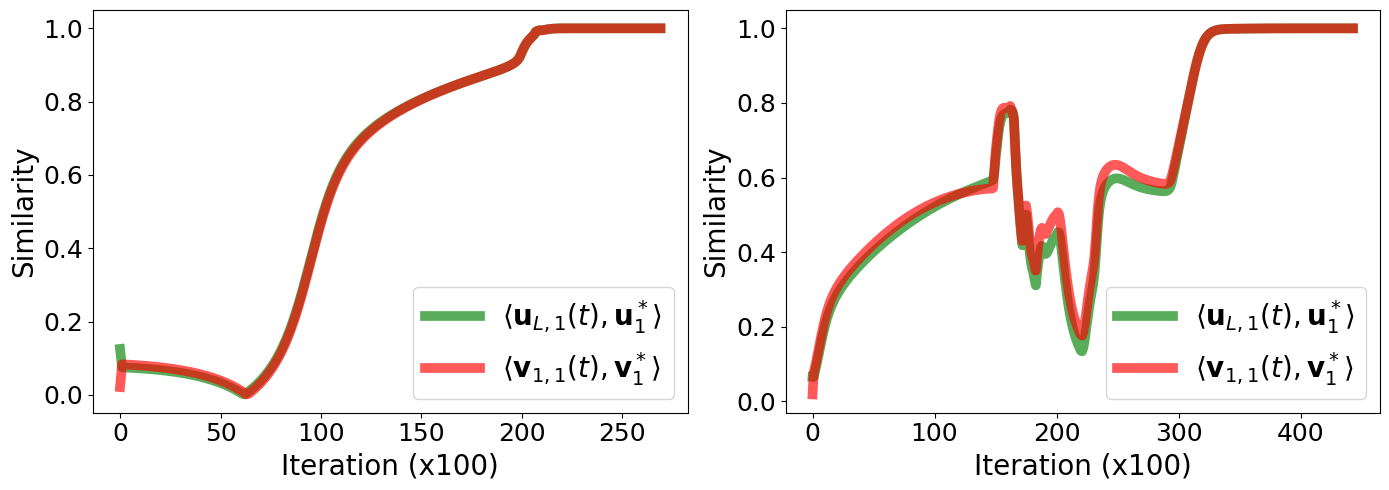

In [14]:
fig = plt.figure(figsize=(14, 5))

ax = fig.add_subplot(121)
ax.plot(U_angle_mf, c='green', linewidth=7, label=r'$\langle \mathbf{u}_{L,1}(t), \mathbf{u}^*_1 \rangle$', alpha=0.65)
ax.plot(V_angle_mf, c='red', linewidth=7, label=r'$\langle \mathbf{v}_{1, 1}(t), \mathbf{v}^*_1 \rangle$', alpha=0.65)
ax.set_xlabel(rf'Iteration (x{n_inner_loops})', fontsize=20)
ax.set_ylabel('Similarity', fontsize=20)
ax.legend(fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)

ax = fig.add_subplot(122)
ax.plot(U_angle_mc, c='green', linewidth=7, label=r'$\langle \mathbf{u}_{L, 1}(t), \mathbf{u}^*_1 \rangle$', alpha=0.65)
ax.plot(V_angle_mc, c='red', linewidth=7, label=r'$\langle \mathbf{v}_{1,1}(t), \mathbf{v}^*_1 \rangle$', alpha=0.65)
ax.set_xlabel(rf'Iteration (x{n_inner_loops})', fontsize=20)
ax.set_ylabel('Similarity', fontsize=20)
ax.legend(fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
#ax.set_title(rf'$\epsilon=${init_scale}')

fig.tight_layout()
plt.savefig('figs/pc_dist_mf_mc.png', dpi=300, bbox_inches='tight')